In [2]:
%pip install tensorflowjs

  Using cached tensorflowjs-4.5.0-py3-none-any.whl (85 kB)
  Using cached tensorflowjs-4.4.0-py3-none-any.whl (85 kB)
  Using cached protobuf-3.19.6-cp39-cp39-win_amd64.whl (895 kB)
  Using cached jax-0.4.10.tar.gz (1.3 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached packaging-20.9-py2.py3-none-any.whl (40 kB)
  Using cached flax-0.6.10-py3-none-any.whl (226 kB)
  Using cached tensorflowjs-4.3.0-py3-none-any.whl (85 kB)
  Using cached tensorflowjs-4.2.0-py3-none-any.whl (84 kB)
  Using cached tensorflowjs-4.1.0-py3-none-any.whl (84 kB)
  Using cached tensorflowjs-4.0.0-py3-none-any.whl (83 kB)
  Using cached tensorflowjs-3.21.0-py3-none-any.whl (81 kB)
  Using cached msgpack-1.0.5-cp39-cp39

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.10.0 requires tensorflow<2.11,>=2.10.0; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.9.0 which is incompatible.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.20.0 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import numpy as np
import psycopg2
import pandas
from scipy import stats
from scipy.stats import f_oneway

from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Input, Model, Sequential, regularizers
from tensorflow.keras.layers import concatenate,TimeDistributed, Concatenate, GRU, Activation, SpatialDropout2D, Dropout, Flatten,SeparableConv1D, Dense, SimpleRNN, LSTM, Conv1D, Reshape,MaxPooling1D, Conv2D, Reshape,MaxPooling2D, Permute,Bidirectional, BatchNormalization, DepthwiseConv2D, GlobalMaxPooling2D
from tensorflow.keras.layers import concatenate, Embedding
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,Callback#training callbacks
from tensorflow.keras import optimizers
from tensorflow.keras import models
import tensorflow as tf

import seaborn as sns

import matplotlib.pyplot as plt

In [2]:
connection = psycopg2.connect(
    host="localhost",
    database="ARH_COVID_PATIENTS_DATA",
    user="postgres",
    password="password"
)

In [3]:
"\", \"".join(["Id", "NumberIB"])

'Id", "NumberIB'

In [4]:
class DBConnector:
    def __init__(self):
        self.conn = psycopg2.connect(
            host="localhost",
            database="ARH_COVID_PATIENTS_DATA",
            user="postgres",
            password="password"
        )
        self.cur = self.conn.cursor()
    
    def selectCols(self, colNames=None, colsNotNull=[], limit=0, isDead=None):  
        if colNames:      
            formattedCols = "\", \"".join(colNames)
            sqlText = "select \"" + formattedCols + "\" from \"PATIENTS_DATA\""
        else:
            sqlText = "select * from \"PATIENTS_DATA\""
        if colsNotNull:
            colsNotNullFormatted = "\" is not null and \"".join(colsNotNull)
            sqlText += " where \"" + colsNotNullFormatted + "\" is not null "
            if isDead != None:
                sqlText += " and \"IsDead\" = " + str(isDead)
        if limit > 0 :
            sqlText += "limit " + str(limit)    
        # print(sqlText)    
        self.cur.execute(sqlText)
        return self.cur.fetchall()

In [6]:
dbcon = DBConnector()
df = pandas.DataFrame(dbcon.selectCols())
df.columns = [
"Id",
"NumberIB",
"NumberCard",
"Sex",
"Age",
"IsDead",
"Height",
"Weight",
"BMI",
"IsSmoking",
"IsPregnant",
"MaxDNSeverityCategory",
"MinAbsLymph",
"MaxAbsNeu",
"MaxAbsLeic",
"MaxPlt",
"MaxESR",
"MaxCProtein",
"MaxFerritin",
"MaxProcalcitonin",
"MaxDDimer",
"MaxUrea",
"MaxCommonProtein",
"MaxGlucose",
"MaxALT",
"MaxAST",
"MaxPhosphatase",
"MaxBilirubin",
"MaxLDG",
"MaxMNO",
"MinMNO",
"MaxProtombTime",
"MinProtombTime",
"MinProtrombIndex",
"MaxFibrinogen",
"MaxCreatinine",
"MinHemoglobin",
"MaxLactat",
"MaxProBNP",
"MaxTemp",
"MinSaturation",
"MaxBP",
"MaxFiO2",
"WasInResuscitation",
"CovidVac",
"FluVac",
"PneumococcusVac",
"WasOnIVL",
"IsNotEmployed",
"HasIBS",
"HasMyocardInfarct",
"HasONMK",
"HasHypertonia",
"HasHOBL",
"HasDiabetes",
"HasObesity",
"HasHPN",
"HasCancer",
"HasHIV",
"HasPneumo",
"MaxKT",
"HasAsthma"
]
df.count()

Id            19169
NumberIB      19169
NumberCard    19169
Sex           19067
Age           19169
              ...  
HasCancer     19169
HasHIV        19169
HasPneumo     19169
MaxKT         19169
HasAsthma     19169
Length: 62, dtype: int64

In [10]:
df.to_csv('./full_dataframe')

In [5]:
"\", is not null and \"".join(["Id", "Test"])

'Id", is not null and "Test'

In [5]:
dbcon = DBConnector()
cols = [
    "Sex",
    "Age",
    "IsDead",
    "Weight",
    "IsSmoking",
    "MaxDNSeverityCategory",
    "MinAbsLymph",
    "MaxAbsLeic",
    "MaxPlt",
    "MaxESR",
    "MaxCProtein",
    "MaxFerritin",
    "MaxDDimer",
    "MaxUrea",
    "MaxCommonProtein",
    "MaxGlucose",
    "MaxALT",
    "MaxAST",
    "MaxBilirubin",
    "MaxMNO",
    "MinProtrombIndex",
    "MaxFibrinogen",
    "MaxCreatinine",
    "MinHemoglobin",
    "MaxTemp",
    "MinSaturation",
    "MaxBP",
    "HasIBS",
    "HasMyocardInfarct",
    "HasONMK",
    "HasHypertonia",
    "HasHOBL",
    "HasDiabetes",
    "HasObesity",
    "HasHPN",
    "HasCancer",
    "HasHIV",
    "HasPneumo",
    "MaxKT",
    "HasAsthma",
    "CovidVac",
    "FluVac",
    "PneumococcusVac",
    "WasInResuscitation",
    "WasOnIVL"
]
colsNotNull = [
    "Weight",
    "MaxDNSeverityCategory",
    "MinAbsLymph",
    "MaxAbsLeic",
    "MaxPlt",
    "MaxESR",
    "MaxCProtein",
    "MaxFerritin",
    "MaxDDimer",
    "MaxUrea",
    "MaxCommonProtein",
    "MaxGlucose",
    "MaxALT",
    "MaxAST",
    "MaxBilirubin",
    "MaxMNO",
    "MinProtrombIndex",
    "MaxFibrinogen",
    "MaxCreatinine",
    "MinHemoglobin",
    "MaxTemp",
    "MinSaturation",
    "MaxBP",
    "MaxKT"
]

df = pandas.DataFrame(dbcon.selectCols(cols, colsNotNull), columns=cols)
df.count()

Sex                      7011
Age                      7011
IsDead                   7011
Weight                   7011
IsSmoking                7011
MaxDNSeverityCategory    7011
MinAbsLymph              7011
MaxAbsLeic               7011
MaxPlt                   7011
MaxESR                   7011
MaxCProtein              7011
MaxFerritin              7011
MaxDDimer                7011
MaxUrea                  7011
MaxCommonProtein         7011
MaxGlucose               7011
MaxALT                   7011
MaxAST                   7011
MaxBilirubin             7011
MaxMNO                   7011
MinProtrombIndex         7011
MaxFibrinogen            7011
MaxCreatinine            7011
MinHemoglobin            7011
MaxTemp                  7011
MinSaturation            7011
MaxBP                    7011
HasIBS                   7011
HasMyocardInfarct        7011
HasONMK                  7011
HasHypertonia            7011
HasHOBL                  7011
HasDiabetes              7011
HasObesity

In [ ]:
df.to_csv('./dataframe')

In [5]:
def encode_categorical_params(data, paramName, num_classes):
    for i in range(len(data)):
        data_buf = []
        for k in range(num_classes):
            data_buf.append(0)
        value = data[paramName].iloc[i]
        data_buf[int(value)] = 1
        data_buf = np.asarray(data_buf)
        data[paramName].iloc[i] = data_buf    
    # print(np.asarray(buf))
    # data[paramName] = buf
    

def cast_to_float(data, cols, colsToExclude):
        for column in cols:       
            if column in colsToExclude:
                 continue 
            data[column] = data[column].astype(np.float32)

In [20]:
from scipy.stats import shapiro

# пример выборки
data = df["MaxBilirubin"]

# проверяем нормальность распределения
stat, p = shapiro(data)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Принимаем гипотезу о нормальности распределения')
else:
    print('Отвергаем гипотезу о нормальности распределения')

stat=0.303, p=0.000
Отвергаем гипотезу о нормальности распределения


c:\Users\jeday\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [16]:
df["MinHemoglobin"].skew()

-0.7096370456395131

C:\Users\jeday\AppData\Local\Temp\ipykernel_15872\1067968166.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["MaxBilirubin"],color='red',label='bmi',ax=ax)


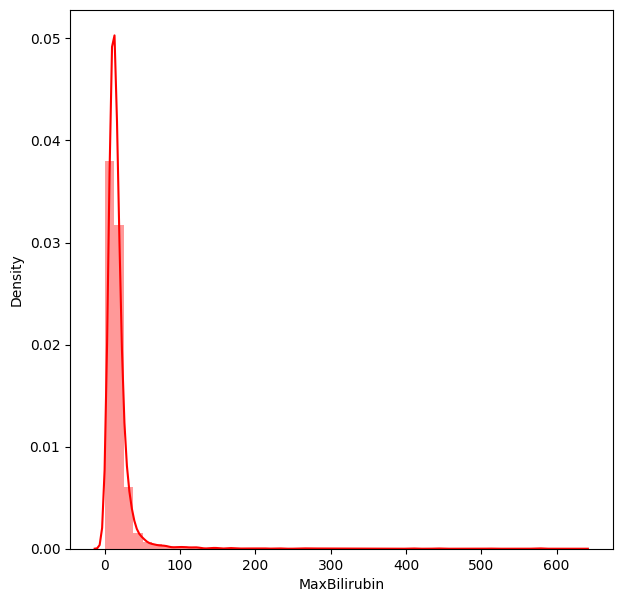

In [21]:
fig = plt.figure
fig,ax= plt.subplots(figsize=(7,7))
sns.distplot(df["MaxBilirubin"],color='red',label='bmi',ax=ax)
plt.show()

In [6]:
encode_categorical_params(df, "MaxKT", 5)
encode_categorical_params(df, "MaxDNSeverityCategory", 3)

C:\Users\jeday\AppData\Local\Temp\ipykernel_23120\472790718.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[paramName].iloc[i] = data_buf


In [14]:
def getParamBounds(valueMin, valueMax):
    return valueMin - valueMin/2, valueMax + valueMax/2

print(getParamBounds(1.7, 7.60))

(0.85, 11.399999999999999)


In [6]:
df_dead = pandas.DataFrame(dbcon.selectCols(cols, colsNotNull, isDead=True), columns=cols)
df_alive = pandas.DataFrame(dbcon.selectCols(cols, colsNotNull, isDead=False), columns=cols)

for colName in cols:
    temp_dead = df_dead[colName]
    temp_alive = df_alive[colName]
    if not isinstance(temp_dead.iloc[0], np.bool_):
        temp_dead = temp_dead.astype(np.float64)
    if not isinstance(temp_alive.iloc[0], np.bool_):
        temp_alive = temp_alive.astype(np.float64)
    # _, p = stats.mannwhitneyu(temp_dead, temp_alive)
    stas, p = f_oneway(temp_dead, temp_alive)
    print(colName, ": ", p)

Sex :  0.14139647102066508
Age :  1.2940463130301765e-106
IsDead :  0.0
Weight :  8.109443037594729e-05
IsSmoking :  1.6504213830453195e-05
MaxDNSeverityCategory :  0.0
MinAbsLymph :  9.83818270738562e-22
MaxAbsLeic :  4.17787106809729e-236
MaxPlt :  1.0480705031136734e-19
MaxESR :  8.392182314178477e-15
MaxCProtein :  3.1627003972221957e-280
MaxFerritin :  2.738161900653864e-168
MaxDDimer :  2.376172016855249e-184
MaxUrea :  0.0
MaxCommonProtein :  4.10055352391806e-18
MaxGlucose :  8.319997622289862e-05
MaxALT :  6.165115634856644e-43
MaxAST :  2.7139698147030826e-38
MaxBilirubin :  5.1268069687843434e-45
MaxMNO :  3.143761346558646e-69
MinProtrombIndex :  9.743038526553437e-242
MaxFibrinogen :  9.310816407871294e-23
MaxCreatinine :  2.4353232299287506e-197
MinHemoglobin :  6.038008318272501e-70
MaxTemp :  2.5039872015254193e-23
MinSaturation :  8.79219022308552e-157
MaxBP :  3.87427281366287e-201
HasIBS :  2.573294819347243e-51
HasMyocardInfarct :  5.48522003351452e-89
HasONMK :  2.

c:\Users\jeday\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_stats_py.py:3895: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


<Axes: xlabel='IsDead', ylabel='MaxAbsLeic'>

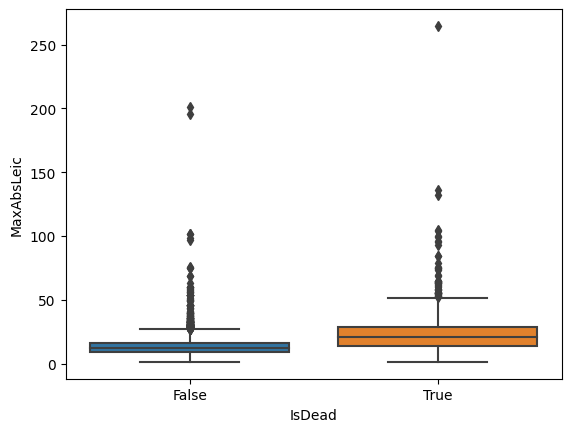

In [27]:
sns.boxplot(y=df["MaxAbsLeic"].astype(np.float32), x=df["IsDead"])

In [ ]:
sns.pairplot(data=df, diag_kind='kde')

In [8]:
import matplotlib.pyplot as plt 

#detect correlation. pay attention for the last column - predicted value.
corr = df.corr(method = 'pearson')#pearson spearman kendall #pearson - defalut

#resize table
fig, ax = plt.subplots(figsize=(50,50))         # Sample figsize in inches
sns.heatmap(corr, annot=True, linewidths=.5, ax=ax, vmax=1,vmin=-1)

C:\Users\jeday\AppData\Local\Temp\ipykernel_23120\2820036689.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr(method = 'pearson')#pearson spearman kendall #pearson - defalut


<Axes: >

Error in callback <function flush_figures at 0x000001C2DEBB8040> (for post_execute):


KeyboardInterrupt: 

In [8]:
df["IsDead"].value_counts()

False    5493
True     1518
Name: IsDead, dtype: int64

In [ ]:
print('Duplicates:', sum(df["NumberCard"].duplicated()))

In [9]:
df[["MaxKT", "MaxDNSeverityCategory"]]

,MaxKT,MaxDNSeverityCategory
0,"[0, 1, 0, 0, 0]","[0, 0, 1]"
1,"[0, 0, 0, 1, 0]","[0, 0, 1]"
2,"[0, 1, 0, 0, 0]","[1, 0, 0]"
3,"[0, 0, 0, 1, 0]","[0, 0, 1]"
4,"[0, 0, 1, 0, 0]","[0, 1, 0]"
...,...,...
7006,"[1, 0, 0, 0, 0]","[0, 1, 0]"
7007,"[1, 0, 0, 0, 0]","[0, 0, 1]"
7008,"[1, 0, 0, 0, 0]","[0, 1, 0]"
7009,"[1, 0, 0, 0, 0]","[0, 1, 0]"


In [10]:
parameters= df.drop(["IsDead"], axis='columns')
cast_to_float(parameters, cols, ["IsDead", "MaxDNSeverityCategory", "MaxKT"])
# categorical_params = df["MaxKT"]
labels = df["IsDead"]

In [11]:
# def callback_conver(val):
#     if isinstance(val, np.ndarray):
#         return np.array(val)
#     else:
#         return val.astype(np.float32)

# parameters = np.array([callback_conver(val) for val in parameters.values])
print(parameters.iloc[0])

NameError: name 'parameters' is not defined

In [33]:
def search_for_null(data):
    return len(list(filter(lambda x: x == None, data)))

for colName in cols:
    print(colName, search_for_null(df[colName]))


Sex 0
Age 0
IsDead 0
Weight 0
IsSmoking 0
IsPregnant 0


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [16]:
print(parameters[:10])

   Sex   Age  Weight  IsSmoking  IsPregnant MaxDNSeverityCategory  \
0  1.0  86.0    60.0        0.0         0.0             [0, 0, 1]   
1  1.0  64.0    85.0        0.0         0.0             [0, 0, 1]   
2  1.0  48.0    53.0        0.0         0.0             [1, 0, 0]   
3  0.0  90.0    70.0        0.0         0.0             [0, 0, 1]   
4  0.0  54.0    85.0        0.0         0.0             [0, 1, 0]   
5  1.0  78.0    90.0        0.0         0.0             [0, 1, 0]   
6  0.0  89.0    75.0        1.0         0.0             [0, 0, 1]   
7  0.0  54.0    86.0        0.0         0.0             [1, 0, 0]   
8  0.0  48.0    94.0        0.0         0.0             [0, 1, 0]   
9  1.0  83.0    50.0        0.0         0.0             [0, 1, 0]   

   MinAbsLymph  MaxAbsLeic  MaxPlt  MaxESR  ...  HasCancer  HasHIV  HasPneumo  \
0         0.99   25.030001   346.0    38.0  ...        0.0     0.0        1.0   
1         0.47   11.320000   240.0    38.0  ...        0.0     0.0        1.0 

In [11]:
from sklearn.model_selection import train_test_split

test_split = 0.2

parameters_train_df, parameters_testval_df, labels_train_df, labels_testval_df = train_test_split(
    parameters,
    labels.astype(np.float32),
    test_size=test_split,
    random_state=42,
    shuffle=True
)

parameters_val_df, parameters_test_df, labels_val_df, labels_test_df = train_test_split(
    parameters_testval_df,
    labels_testval_df,
    test_size=0.5,
    random_state=42,
    shuffle=True
)

print("training set of parameters: ", len(parameters_train_df))
print("val set of parameters:", len(parameters_val_df))
print("test set of parameters:", len(parameters_test_df))
print("training set of labels", len(labels_train_df))
print("val set of labels", len(labels_val_df))
print("test set of labels", len(labels_test_df))

training set of parameters:  5608
val set of parameters: 701
test set of parameters: 702
training set of labels 5608
val set of labels 701
test set of labels 702


In [12]:
numeric_train_data = parameters_train_df.drop(["MaxDNSeverityCategory", "MaxKT"], axis='columns')
dn_category_train_data = np.asarray([np.asarray(val) for val in parameters_train_df["MaxDNSeverityCategory"]])
kt_category_train_data = np.asarray([np.asarray(val) for val in parameters_train_df["MaxKT"]])

numeric_val_data = parameters_val_df.drop(["MaxDNSeverityCategory", "MaxKT"], axis='columns')
dn_category_val_data = np.asarray([np.asarray(val) for val in parameters_val_df["MaxDNSeverityCategory"]])
kt_category_val_data = np.asarray([np.asarray(val) for val in parameters_val_df["MaxKT"]])

numeric_test_data = parameters_test_df.drop(["MaxDNSeverityCategory", "MaxKT"], axis='columns')
dn_category_test_data = np.asarray([np.asarray(val) for val in parameters_test_df["MaxDNSeverityCategory"]])
kt_category_test_data = np.asarray([np.asarray(val) for val in parameters_test_df["MaxKT"]])

In [13]:
#create model

input_shape_numeric = (numeric_train_data.shape[1])
model_input_numeric = Input(shape=input_shape_numeric)
dense_4_n = Dense(32, activation="relu")(model_input_numeric)

input_shape_dn = (dn_category_train_data.shape[1])
model_input_dn = Input(shape=input_shape_dn)
dense_4_dn = Dense(16, activation="relu")(model_input_dn)

input_shape_kt = (kt_category_train_data.shape[1])
model_input_kt = Input(shape=input_shape_kt)
dense_4_kt = Dense(16, activation="relu")(model_input_kt)

concatenate = Concatenate()([dense_4_n, dense_4_dn, dense_4_kt])
out = Dense(1, activation="sigmoid")(concatenate)
model = Model([model_input_numeric, model_input_dn, model_input_kt], out)
loss = 'binary_crossentropy'
optimizer = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
metrics='accuracy'
model.compile(optimizer=optimizer,loss=loss,metrics=[metrics, tf.keras.metrics.BinaryIoU(name='io_u')])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 41)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 32)           1344        ['input_1[0][0]']                
                                                                                              

c:\Users\jeday\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [16]:
check_path = './model-checkpoints'

In [14]:
from sklearn.utils import class_weight

class_sample_weights = class_weight.compute_sample_weight('balanced', labels_train_df)

Epoch 1/100
561/561 [==============================] - 8s 10ms/step - loss: 16.3489 - accuracy: 0.4568 - io_u: 0.2722 - val_loss: 6.2733 - val_accuracy: 0.5592 - val_io_u: 0.3528
Epoch 2/100
561/561 [==============================] - 5s 9ms/step - loss: 5.8400 - accuracy: 0.6138 - io_u: 0.4048 - val_loss: 4.5331 - val_accuracy: 0.6391 - val_io_u: 0.4350
Epoch 3/100
561/561 [==============================] - 5s 9ms/step - loss: 3.5066 - accuracy: 0.6899 - io_u: 0.4808 - val_loss: 2.7339 - val_accuracy: 0.7247 - val_io_u: 0.5143
Epoch 4/100
561/561 [==============================] - 5s 8ms/step - loss: 2.4460 - accuracy: 0.7277 - io_u: 0.5215 - val_loss: 1.9939 - val_accuracy: 0.7518 - val_io_u: 0.5439
Epoch 5/100
561/561 [==============================] - 4s 8ms/step - loss: 1.8922 - accuracy: 0.7516 - io_u: 0.5489 - val_loss: 1.8248 - val_accuracy: 0.7461 - val_io_u: 0.5467
Epoch 6/100
561/561 [==============================] - 5s 9ms/step - loss: 1.5512 - accuracy: 0.7591 - io_u: 0.55

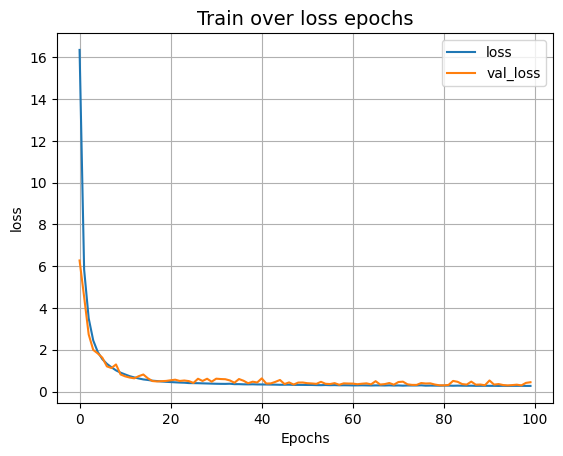

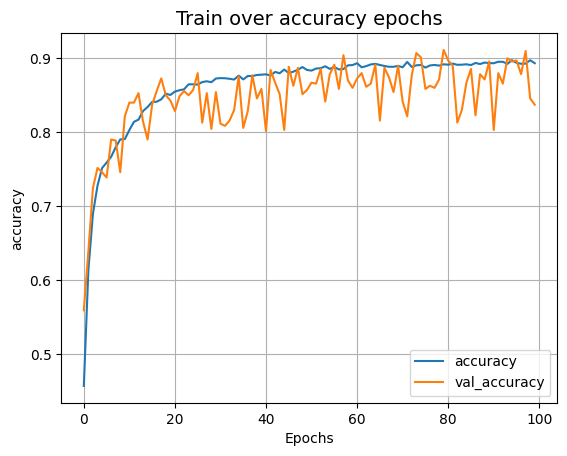

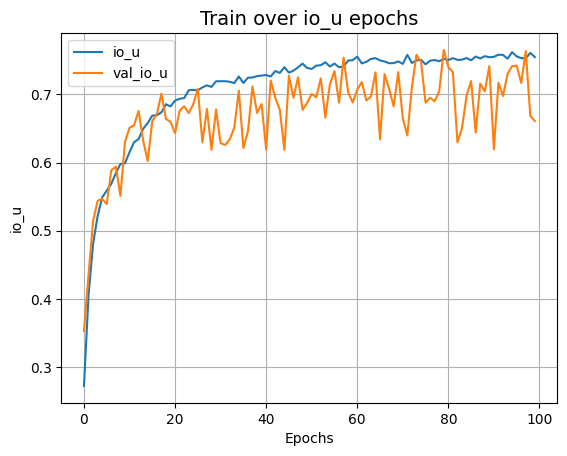

In [17]:
epochs = 100

callbacks = [
     ModelCheckpoint(check_path, monitor='val_io_u', save_best_only=True, verbose=0),
]

history = model.fit(
    [numeric_train_data, dn_category_train_data, kt_category_train_data],
    labels_train_df,
    validation_data=([
        numeric_val_data, 
        dn_category_val_data, 
        kt_category_val_data], 
    labels_val_df),               
    epochs = epochs,
    batch_size=10,
    callbacks=callbacks,
    sample_weight = class_sample_weights
)

def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_"+item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train over {} epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

plot_result("loss")
plot_result("accuracy")
plot_result("io_u")

In [20]:
save_path = './model-saved'
save_path_tfjs = './model-saved-tfjs'

In [8]:
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model, save_path_tfjs)

In [29]:
model.save(save_path)

INFO:tensorflow:Assets written to: ./model-saved\assets


In [9]:
model = model.load(save_path)

NameError: name 'model' is not defined

In [21]:
from keras.models import load_model

model = load_model(save_path)

In [22]:
loss, acc, mean_io_u = model.evaluate([numeric_test_data, dn_category_test_data, kt_category_test_data], labels_test_df)
print(f"Accuracy on the test set: {round(acc *100, 2)}%")

22/22 [==============================] - 2s 6ms/step - loss: 0.3228 - accuracy: 0.9003 - io_u: 0.7724
Accuracy on the test set: 90.03%


In [24]:
predictions_result = model.predict([numeric_test_data, dn_category_test_data, kt_category_test_data])
print(predictions_result)

22/22 [==============================] - 0s 2ms/step
[[9.81209099e-01]
 [1.19877281e-04]
 [2.85508782e-01]
 [8.91221106e-01]
 [2.63103489e-02]
 [9.37449574e-01]
 [1.83084961e-02]
 [9.94792998e-01]
 [3.03795218e-01]
 [9.92863595e-01]
 [8.34580898e-01]
 [9.70360935e-01]
 [3.79995368e-02]
 [6.80289447e-01]
 [5.54753328e-03]
 [1.05249435e-01]
 [5.90756357e-01]
 [4.05863523e-01]
 [2.79310532e-02]
 [5.22729009e-02]
 [8.32719564e-01]
 [6.93390131e-01]
 [6.10502303e-01]
 [8.50593578e-03]
 [8.93072903e-01]
 [9.97956276e-01]
 [9.66965020e-01]
 [2.29376573e-02]
 [1.43474817e-01]
 [1.34647349e-02]
 [1.65397435e-01]
 [5.09686843e-02]
 [2.06979752e-01]
 [1.82400897e-01]
 [4.24106931e-03]
 [1.45030499e-01]
 [9.14649904e-01]
 [4.35666181e-02]
 [4.03435677e-02]
 [1.52965114e-02]
 [1.18931700e-02]
 [8.45758796e-01]
 [9.91974890e-01]
 [3.88096273e-01]
 [1.61111187e-02]
 [9.23988337e-05]
 [7.49386149e-03]
 [3.34003210e-01]
 [7.64420807e-01]
 [9.52397212e-02]
 [9.69590992e-03]
 [8.66680920e-01]
 [1.6999553

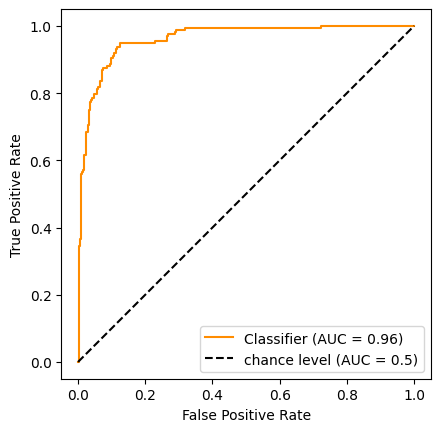

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    labels_test_df,
    predictions_result,
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()